## Competition

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

In [29]:
def power_competition(n,B,m=150):
        
   np.random.seed(42)

   esperances = []
   variances = []
   test_statistics = []
   test_alternative = []
   power = []

   beta1 = 2
   beta2_values = np.linspace(0, 0.16, 9)
 
   epsilon = np.random.normal(0, 1, n)
   x = np.random.uniform(0, 5, n)

   epsilon_test = np.random.normal(0, 1, m)
   x_test = np.random.uniform(0, 5, m)

   bootstrap_indices = np.random.choice(n, size=(B, n), replace=True) # bootstrapping

   for beta2 in beta2_values:
       
       y = beta1 * x + beta2 * x**2 + epsilon 
       y_test = beta1 * x_test + beta2 * x_test**2 + epsilon_test

       db = []
       
       for bootstrap_index in bootstrap_indices:
       
          x_train = x[bootstrap_index]
          y_train = beta1 * x_train + beta2 * x_train**2 + epsilon[bootstrap_index]

          x_train_reshape = x_train.reshape(-1, 1) # fit pour le modèle 

          model_a1 = LinearRegression().fit(x_train_reshape, y_train) # Modèle linéaire
          y_pred_a1 = model_a1.predict(x_test.reshape(-1,1))
          p1b = mean_squared_error(y_test, y_pred_a1)

          x_train_quad = np.column_stack((x_train, x_train**2))
          x_test_quad = np.column_stack((x_test, x_test**2))

          model_a2 = LinearRegression().fit(x_train_quad, y_train)          
          y_pred_a2 = model_a2.predict(x_test_quad)
          p2b = mean_squared_error(y_test, y_pred_a2)

          db.append(p1b - p2b)  # Différence des moyennes de performance sur chaque bootstrap

       # Fin du boostrapping

       d_barre = sum(db)/B # Converge p.s vers l'espérance mu

       var = np.var(db, ddof=1)
       test_stat = (B**0.5)*d_barre/np.sqrt(var) # Statistique pour l'hypothèse nulle

       delta = np.mean(db)
       student = stats.t.ppf(0.95, df=B-1)
       mu = (B ** 0.5)*delta/np.sqrt(var)
       test_alt = student - mu
       puissance = 1 - stats.norm.cdf(student - mu, 0, 1)
       
       esperances.append(d_barre)
       variances.append(var)
       test_statistics.append(test_stat)
       test_alternative.append(test_alt)
       power.append(puissance)

   return esperances, variances, test_statistics, test_alternative, power


In [30]:
from sklearn.model_selection import GridSearchCV

# On cherche le meilleur B

beta2_values = np.linspace(0, 0.16, 9)
param_grid = {'n_bootstrap': [2, 10, 25, 50, 75, 100, 200, 500]}

def evaluate_model_with_bootstrap(n, n_bootstrap):
    esperances, variances, test_statistics, test_alternative, power = power_competition(n, n_bootstrap)
    delta_beta = np.diff(beta2_values)
    delta_puissance = np.diff(power)
    derivative = delta_puissance / delta_beta
    variance_derivative = np.var(derivative)
    return variance_derivative

best_score = +np.inf
best_params = None
for n_bootstrap in param_grid['n_bootstrap']:
    score = evaluate_model_with_bootstrap(150, n_bootstrap)
    if score < best_score:
        best_score = score      
        best_params = n_bootstrap

print(f'Best number of bootstraps: {best_params}, with score: {best_score}')


Best number of bootstraps: 2, with score: 0.6448340673786462


In [31]:
esperances, variances, test_statistics, test_alternative, power = power_competition(n=150, B=75)

print(f"Espérances: {esperances}")
print(f"Variances: {variances}")
print(f"Statistiques de test: {test_statistics}")
print(f"Test alternative: {test_alternative}")
print(f"Puissance: {power}")


Espérances: [-0.00414080092495924, -0.008526117521322521, -0.010403566572429163, -0.009773148078279191, -0.006634862038872546, -0.0009887084542092891, 0.007165312675710475, 0.017827201350887025, 0.03099695757132015]
Variances: [0.0001611820121114337, 0.00016036684401315505, 0.0001628241385404593, 0.00016839988592330822, 0.00017696022490167501, 0.0001883914427255294, 0.00020259997515485628, 0.00021951240645964762, 0.00023907546941989702]
Statistiques de test: [-2.8245983226190385, -5.830753142217667, -7.060793132622809, -6.522201534346128, -4.319412669050986, -0.6238329263604379, 4.359594383919606, 10.420397018700898, 17.361298012070076]
Test alternative: [4.490305215353062, 7.49646003495169, 8.726500025356833, 8.187908427080151, 5.985119561785009, 2.289539819094461, -2.6938874911855826, -8.754690125966873, -15.695591119336052]
Puissance: [3.5560594003891666e-06, 3.275157922644212e-14, 0.0, 1.1102230246251565e-16, 1.0811548323275133e-09, 0.011024003541764804, 0.9964688000099029, 1.0, 1.

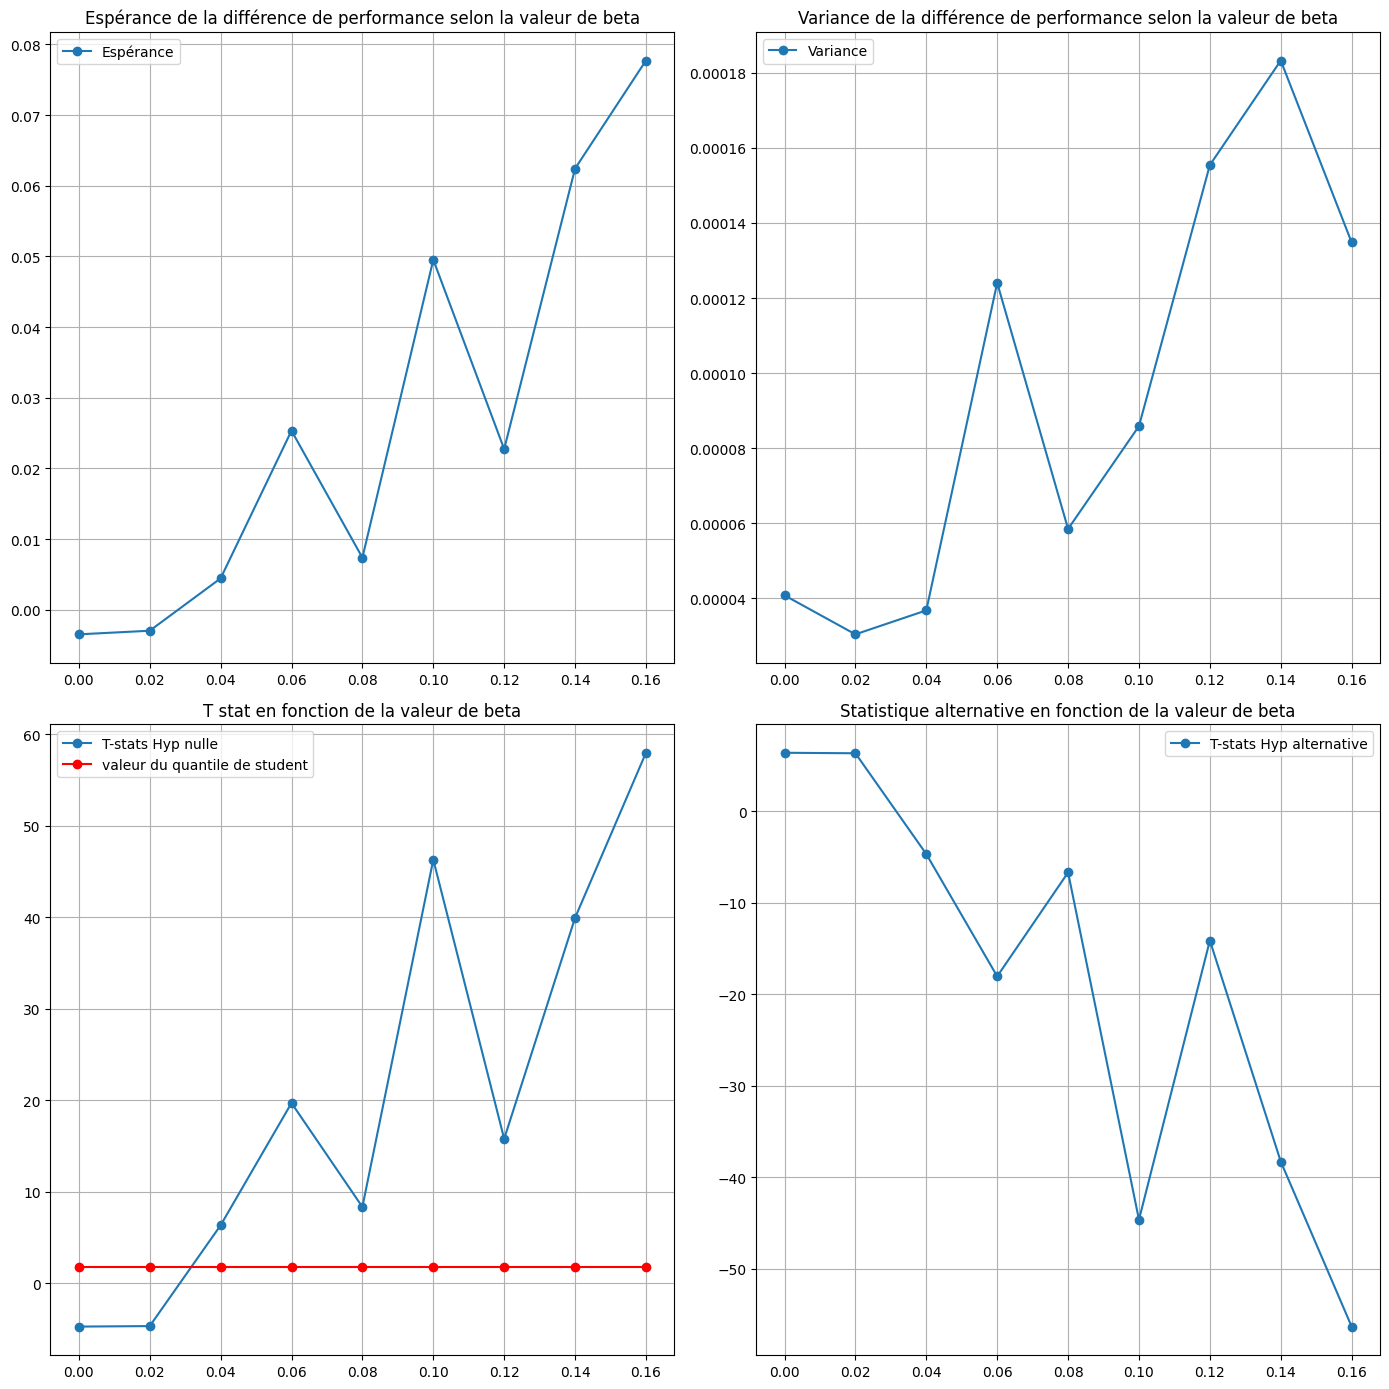

In [26]:
beta2_values = np.linspace(0, 0.16, 9)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))

# Premier sous-graphe : Espérance
axes[0, 0].plot(beta2_values, esperances, label='Espérance', marker='o')
axes[0, 0].set_title('Espérance de la différence de performance selon la valeur de beta')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Deuxième sous-graphe : Variance
axes[0, 1].plot(beta2_values, variances, label='Variance', marker='o')
axes[0, 1].set_title('Variance de la différence de performance selon la valeur de beta')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Troisième sous-graphe : T-stat Hyp nulle
axes[1, 0].plot(beta2_values, test_statistics, label='T-stats Hyp nulle', marker='o')
axes[1, 0].plot(beta2_values, [stats.t.ppf(0.95, df=9)]*len(beta2_values), label='valeur du quantile de student', color='r', marker='o')
axes[1, 0].set_title('T stat en fonction de la valeur de beta')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Quatrième sous-graphe : T-stat Hyp alternative
axes[1, 1].plot(beta2_values, test_alternative, label='T-stats Hyp alternative', marker='o')
axes[1, 1].set_title('Statistique alternative en fonction de la valeur de beta')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

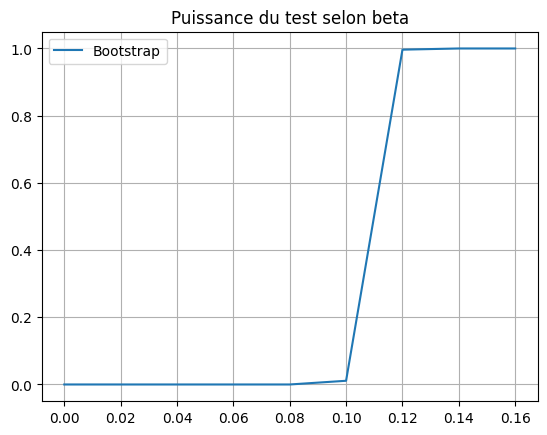

In [32]:
plt.figure()
plt.title("Puissance du test selon beta")
plt.plot(beta2_values, power, label = "Bootstrap")
plt.grid()
plt.legend()
plt.show()

In [28]:
df_comp = pd.DataFrame(power)
df_comp

,0
0,8.285372e-11
1,1.174622e-10
2,9.999985e-01
3,1.000000e+00
4,1.000000e+00
5,1.000000e+00
6,1.000000e+00
7,1.000000e+00
8,1.000000e+00
